# CS 3300 Data Science - Lab 6: Exploratory Data Analysis with Clustering

## Stuart Harley

### Introduction

In this lab we are continuing our exploration of our json emails. As in the last lab, we perform dimensionality reduction using the Truncated SVD method. Then we cluster the data use a clustering approach, I used DBSCAN. We cluster the emails into two distinct clusters using DBSCAN and then perform some analysis on the resulting clusters. Part of this analysis is to determine significantly significant words contained in the clusters.

### Importing Libraries

In [1]:
import glob
import json
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
from scipy.sparse import csc_matrix
from scipy import stats

### Part I: Loading and Transforming the data

Loading in email json files and putting the data into a pandas dataframe.

In [2]:
files = glob.glob('email_json/*', recursive=True)
email_list = []
for file in files:
    with open(file) as file:
        email_list.append(json.load(file))
df = pd.DataFrame.from_records(email_list)
df['category'] = df['category'].astype('category')

In [3]:
df.head()

,body,category,from_address,subject,to_address
0,\n\n\n\n\n\n\nDo you feel the pressure to perf...,spam,"""Tomas Jacobs"" <RickyAmes@aol.com>","Generic Cialis, branded quality@",the00@speedy.uwaterloo.ca
1,"Hi, i've just updated from the gulus and I che...",ham,Yan Morin <yan.morin@savoirfairelinux.com>,Typo in /debian/README,debian-mirrors@lists.debian.org
2,authentic viagra\n\nMega authenticV I A G R A...,spam,"""Sheila Crenshaw"" <7stocknews@tractionmarketin...",authentic viagra,<the00@plg.uwaterloo.ca>
3,"\nHey Billy, \n\nit was really fun going out t...",spam,"""Stormy Dempsey"" <vqucsmdfgvsg@ruraltek.com>",Nice talking with ya,opt4@speedy.uwaterloo.ca
4,"\n\n\n\n\n\n\nsystem"" of the home. It will ha...",spam,"""Christi T. Jernigan"" <dcube@totalink.net>",or trembling; stomach cramps; trouble in sleep...,ktwarwic@speedy.uwaterloo.ca


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63542 entries, 0 to 63541
Data columns (total 5 columns):
body            63542 non-null object
category        63542 non-null category
from_address    63542 non-null object
subject         63410 non-null object
to_address      63141 non-null object
dtypes: category(1), object(4)
memory usage: 2.0+ MB


Using a count vectorizer to put the word counts into a sparse matrix. We us a binary=true option that makes this matrix only keep track of whether or not the word is in an email instead of the actual counts. We also specify min_df=10 to exclude any words that do not appear in at least 10 emails.

In [5]:
vectorizer = CountVectorizer(binary=True, min_df=10)
word_matrix = vectorizer.fit_transform(df['body'])
word_matrix

<63542x32144 sparse matrix of type '<class 'numpy.int64'>'
	with 6388795 stored elements in Compressed Sparse Row format>

Transforming the feature matrix into a SVD projection matrix with 10 columns.

In [6]:
svd = TruncatedSVD(n_components=10)
svd_matrix = svd.fit_transform(word_matrix)
svd_matrix.shape

(63542, 10)

### Part II: Clustering the Emails

To perform further analysis, we want to cluster the emails. Each message will be assigned a cluster id (0, 1, 2, etc.). I decided to use the DBSCAN algorithm since it works for non-flat geometry and uneven sized clusters. However, I did not want any of the points to be considered as noise so I chose an epsilon value of 1 and a min_samples value of 3 for this to be true. I chose these values by looking at a plot of the data beforehand.

In [7]:
clustering = DBSCAN(eps=1, min_samples=3).fit(svd_matrix[:,0:2])
df['clusterID'] = clustering.labels_
np.where(df['clusterID']) == -1 # Represents any points classified as noise

False

Plotting the points according to their cluster. The points form 2 distinct clusters which when looking at the plot, makes the most sense.

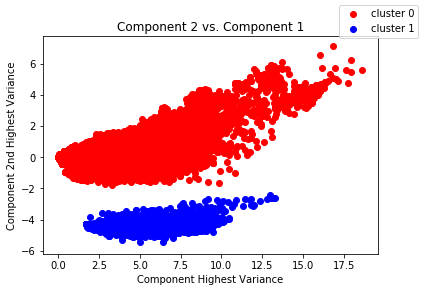

In [8]:
fig, axes = plt.subplots()
cluster0 = np.where(df['clusterID'] == 0)
cluster1 = np.where(df['clusterID'] == 1)
axes.set_xlabel('Component Highest Variance')
axes.set_ylabel('Component 2nd Highest Variance')
axes.set_title('Component 2 vs. Component 1')
plt.scatter(svd_matrix[cluster0,0], svd_matrix[cluster0,1], color='r', label='cluster 0')
plt.scatter(svd_matrix[cluster1,0], svd_matrix[cluster1,1], color='b', label='cluster 1')
fig.legend();

Calculating a confusion matrix for the ham/spam labels versus the cluster labels. I convert the spam/ham labels to a binary classification (0 for spam, 1 for ham) to correspond to the values of the clusters. I chose spam to be 0 because in lab 5 we determined that all of the spam emails were in the upper cluster (cluster 0).

In [9]:
df['categoryBinary'] = df['category'].map({'spam': 0, 'ham': 1})
cm = confusion_matrix(df['categoryBinary'], df['clusterID'])

In [10]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix'):
    # http://scikit-learn.org/stable/auto_examples/model_selection/
    # plot_confusion_matrix.html
    plt.figure(figsize=(6, 4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title(title)
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    thresh = cm.max() / 1.5
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:,}".format(cm[i, j]),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

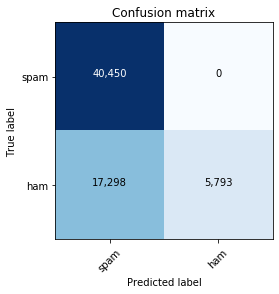

In [11]:
plot_confusion_matrix(cm[1:3, 1:3], target_names=['spam', 'ham'])

### Part III: Calculating Document Frequencies of Words

Creating a separate matrix for each cluster containing the rows for the points in that cluster.

In [12]:
spam_cluster0 = word_matrix[cluster0]
ham_cluster1 = word_matrix[cluster1]

Converting the matrices to CSC format. We will be accessing the data column-wise therefore this will be much faster.

In [13]:
spam_cluster0_csc = csc_matrix(spam_cluster0)
ham_cluster1_csc = csc_matrix(ham_cluster1)
spam_cluster0_csc

<57748x32144 sparse matrix of type '<class 'numpy.longlong'>'
	with 5596708 stored elements in Compressed Sparse Column format>

In [14]:
ham_cluster1_csc

<5793x32144 sparse matrix of type '<class 'numpy.longlong'>'
	with 790768 stored elements in Compressed Sparse Column format>

Calculating the document frequency of each word for each cluster. The document frequemcy is the number of documents that contain each word. Since the feature matrix is binary, we can simply sum along the columns. The resulting matrices have the same shapes with 1 entry (row) for each word in the vocabulary

In [15]:
doc_freq_spam = spam_cluster0_csc.sum(0)
doc_freq_ham = ham_cluster1_csc.sum(0)
doc_freq_spam.shape

(1, 32144)

Finding the column indexes for the words "love", "work", and "different". Then I find the document frequencies for each of these words for each cluster.

In [16]:
feature_words = vectorizer.get_feature_names()
print('Column Index of "love": '+ str(feature_words.index('love')))
print('Column Index of "works": ' + str(feature_words.index('works')))
print('Column Index of "different": ' + str(feature_words.index('different')))

Column Index of "love": 18037
Column Index of "works": 31687
Column Index of "different": 10151


In [17]:
print('Document frequency of "love" - spam cluster(0): ' + str(doc_freq_spam[0,18037])) 
print('Document frequency of "works" - spam cluster(0): ' + str(doc_freq_spam[0,31687])) 
print('Document frequency of "different" - spam cluster(0): ' + str(doc_freq_spam[0,10151])) 

Document frequency of "love" - spam cluster(0): 2020
Document frequency of "works" - spam cluster(0): 2376
Document frequency of "different" - spam cluster(0): 2100


In [18]:
print('Document frequency of "love" - ham cluster(1): ' + str(doc_freq_ham[0,18037])) 
print('Document frequency of "works" - ham cluster(1): ' + str(doc_freq_ham[0,31687])) 
print('Document frequency of "different" - ham cluster(1): ' + str(doc_freq_ham[0,10151])) 

Document frequency of "love" - ham cluster(1): 23
Document frequency of "works" - ham cluster(1): 632
Document frequency of "different" - ham cluster(1): 792


### Part IV: Finding Enriched Words with Statistical Testing

We are using a Binomial test to determine if the number of occurences of a given word in a given cluster is higher than what would be expected from the other cluster.

Our null hypothesis is that the relative document frequencies of the observed clusted are less than or equal to those of the tested. The alternative hypothesis is that the document frequency is higher in cluster 0 (spam) than cluster 1 (ham).

Testing if the words "works" and "love" are enriched in cluster 0.

In [19]:
cluster_1_expected_prob = doc_freq_ham[0,31687] / ham_cluster1.shape[0]
works_pvalue = stats.binom_test(doc_freq_spam[0,31687], spam_cluster0.shape[0],\
                         cluster_1_expected_prob, alternative='greater')

In [20]:
print('"works" p-value: ' + str(works_pvalue))

"works" p-value: 0.9999999999999999


This p-value indicates that the observed frequency of "works" for cluster 0 (spam) is not greater than the frequency for cluster 1 (ham).

In [21]:
cluster_1_expected_prob = doc_freq_ham[0,18037] / ham_cluster1.shape[0]
love_pvalue = stats.binom_test(doc_freq_spam[0,18037], spam_cluster0.shape[0],\
                         cluster_1_expected_prob, alternative='greater')

In [22]:
print('"love" p-value: ' + str(love_pvalue))

"love" p-value: 0.0


This p-value indicates that the observed frequency of "love" for cluster 0 (spam) is greater than the frequency for cluster 1 (ham).

Looping through every word to find enriched words for cluster 0 (spam). To do this, we calculate the p-value of every word. If the p-value < .05, we add that word, its p-value, and its cluster 0 document frequency to a list.

In [23]:
enriched_words = []
for i in range(doc_freq_ham.size):
    cluster_1_expected_prob = doc_freq_ham[0,i] / ham_cluster1.shape[0]
    word_pvalue = stats.binom_test(doc_freq_spam[0,i], spam_cluster0.shape[0],\
                                  cluster_1_expected_prob, alternative='greater')
    if word_pvalue < .05:
        enriched_words.append((word_pvalue, feature_words[i], doc_freq_spam[0,i]))
len(enriched_words)

23952

Filtering out any words that contain non-alphabetic characters.

In [24]:
enriched_words_alpha = []
for word_tuple in enriched_words:
    if word_tuple[1].isalpha():
        enriched_words_alpha.append(word_tuple)
len(enriched_words_alpha)

20273

Sorting the words in ascending order by their p-values and printing out the first 200 words. 

In [25]:
enriched_words_alpha_sorted = sorted(enriched_words_alpha, key=lambda x: x[0])

In [26]:
print(enriched_words_alpha_sorted[0:200])

[(0.0, 'aacs', 16), (0.0, 'aback', 10), (0.0, 'abandoning', 14), (0.0, 'abartlet', 166), (0.0, 'abated', 58), (0.0, 'abating', 29), (0.0, 'abba', 18), (0.0, 'abbas', 30), (0.0, 'abbott', 71), (0.0, 'abducted', 13), (0.0, 'abduction', 13), (0.0, 'abdul', 24), (0.0, 'abe', 18), (0.0, 'abecedarian', 23), (0.0, 'aber', 187), (0.0, 'abfao', 37), (0.0, 'abflauen', 12), (0.0, 'abgeschlossen', 21), (0.0, 'abhorred', 123), (0.0, 'abiding', 24), (0.0, 'abilities', 65), (0.0, 'abiword', 13), (0.0, 'ablaze', 13), (0.0, 'ableton', 577), (0.0, 'abnormal', 14), (0.0, 'aboard', 60), (0.0, 'abode', 24), (0.0, 'abominable', 13), (0.0, 'abortion', 78), (0.0, 'abortions', 15), (0.0, 'abound', 15), (0.0, 'abroad', 212), (0.0, 'abrupt', 12), (0.0, 'abruptly', 81), (0.0, 'absently', 11), (0.0, 'absentminded', 11), (0.0, 'absorbs', 12), (0.0, 'absorption', 28), (0.0, 'abstracted', 22), (0.0, 'abstraction', 40), (0.0, 'absurd', 34), (0.0, 'absurdity', 10), (0.0, 'absurdly', 12), (0.0, 'abundantly', 14), (0.0, 

Repeating with the clusters reversed to find the enriched words in cluster 1 (ham).

In [27]:
enriched_words_1 = []
for i in range(doc_freq_ham.size):
    cluster_0_expected_prob = doc_freq_spam[0,i] / spam_cluster0.shape[0]
    word_pvalue = stats.binom_test(doc_freq_ham[0,i], ham_cluster1.shape[0],\
                                  cluster_0_expected_prob, alternative='greater')
    if word_pvalue < .05:
        enriched_words_1.append((word_pvalue, feature_words[i], doc_freq_ham[0,i]))
len(enriched_words_1)

5387

Filtering out any words that contain non-alphabetic characters.

In [28]:
enriched_words_1_alpha = []
for word_tuple in enriched_words_1:
    if word_tuple[1].isalpha():
        enriched_words_1_alpha.append(word_tuple)
len(enriched_words_1_alpha)

4550

Sorting the words in ascending order by their p-values and printing out the first 200 words.

In [29]:
enriched_words_alpha_1_sorted = sorted(enriched_words_1_alpha, key=lambda x: x[0])

In [30]:
print(enriched_words_alpha_1_sorted[0:200])

[(0.0, 'abline', 66), (0.0, 'ac', 566), (0.0, 'acafs', 36), (0.0, 'adai', 21), (0.0, 'adaikalavan', 11), (0.0, 'adschai', 65), (0.0, 'advance', 618), (0.0, 'affymetrix', 11), (0.0, 'agingandhealth', 50), (0.0, 'alin', 40), (0.0, 'alternative', 1511), (0.0, 'am', 2224), (0.0, 'amicogodzilla', 10), (0.0, 'and', 5781), (0.0, 'andrewpr', 11), (0.0, 'annis', 11), (0.0, 'anova', 131), (0.0, 'anup', 28), (0.0, 'any', 2093), (0.0, 'anyone', 763), (0.0, 'aov', 46), (0.0, 'archive', 481), (0.0, 'arima', 16), (0.0, 'autocorrelation', 17), (0.0, 'autoregressive', 10), (0.0, 'axis', 241), (0.0, 'banyu', 10), (0.0, 'barata', 11), (0.0, 'barplot', 40), (0.0, 'barplots', 13), (0.0, 'batchfiles', 23), (0.0, 'bayesianfilter', 18), (0.0, 'bendix', 10), (0.0, 'bengtsson', 13), (0.0, 'benilton', 24), (0.0, 'bfgs', 48), (0.0, 'bhagavad', 12), (0.0, 'bic', 42), (0.0, 'biddle', 10), (0.0, 'biglm', 10), (0.0, 'biobase', 18), (0.0, 'biocomputing', 10), (0.0, 'bioconductor', 64), (0.0, 'bioinformation', 11), (0.

### Reflection Questions

a. The emails might form 2 distinct clusters because of the two main types of emails (spam and ham). The words in a typical spam email are different than the words in a typically work/normal email therefore they are sorted into 2 distinct clusters.

b. Spam emails are only contained in cluster 0. Ham messages are in both cluster 1 and 0. Therefore, cluster 1 is only made up of ham emails, but cluster 0 contains both spam and ham emails.

c. When examining the first 200 significant words in cluster 1 (ham), there seem to be a lot of words relating to data science. Cluster 0 (spam) contains words more common to spam emails, like "abortions".

d. Printing the first 25 rows from the DataFrame for each cluster.

In [31]:
df[df['clusterID'] == 0].head(25)

,body,category,from_address,subject,to_address,clusterID,categoryBinary
0,\n\n\n\n\n\n\nDo you feel the pressure to perf...,spam,"""Tomas Jacobs"" <RickyAmes@aol.com>","Generic Cialis, branded quality@",the00@speedy.uwaterloo.ca,0,0
1,"Hi, i've just updated from the gulus and I che...",ham,Yan Morin <yan.morin@savoirfairelinux.com>,Typo in /debian/README,debian-mirrors@lists.debian.org,0,1
2,authentic viagra\n\nMega authenticV I A G R A...,spam,"""Sheila Crenshaw"" <7stocknews@tractionmarketin...",authentic viagra,<the00@plg.uwaterloo.ca>,0,0
3,"\nHey Billy, \n\nit was really fun going out t...",spam,"""Stormy Dempsey"" <vqucsmdfgvsg@ruraltek.com>",Nice talking with ya,opt4@speedy.uwaterloo.ca,0,0
4,"\n\n\n\n\n\n\nsystem"" of the home. It will ha...",spam,"""Christi T. Jernigan"" <dcube@totalink.net>",or trembling; stomach cramps; trouble in sleep...,ktwarwic@speedy.uwaterloo.ca,0,0
5,\n\n\n\n\n\n\nthe program and the creative abi...,spam,"""Bobby L. Fleming"" <zvyrepeated@liselebel.com>",Which is duty,manager@speedy.uwaterloo.ca,0,0
6,\n\n\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t...,spam,"""Esteban Everett"" <dbmagyrln@dbmag.com>",Theorize get inside for local esc0rts who do i...,"""Theorize"" <theorize@plg.uwaterloo.ca>",0,0
7,\n\n\n\n\n\n HoodiaLife - Start Losing Weight ...,spam,Real Loss <fibond@terra.com.do>,Losing Weight Quickly,theorize@plg.uwaterloo.ca,0,0
9,\n\n\n\n\n\n\nGood day!\nVisit our new online ...,spam,"""Billy Chin"" <boxer@0733.com>",For Smile,<smile@speedy.uwaterloo.ca>,0,0
10,\nCheck out the wonders of pound melting\n\n\n...,spam,"""Josie Abernathy"" <cebcalhounrennerhog@calhoun...",Less weight - more pleasure and joy,ftp@plg.uwaterloo.ca,0,0


In [32]:
df[df['clusterID'] == 1].head(25)

,body,category,from_address,subject,to_address,clusterID,categoryBinary
8,\nHi...\n\nI have to use R to find out the 90%...,ham,"""Jochen.F"" <jjfahr@ucalgary.ca>",[R] Confidence-Intervals.... help...,r-help@stat.math.ethz.ch,1,1
16,Hm... sounds like a homework problem to me...\...,ham,"""Sarah Goslee"" <sarah.goslee@gmail.com>",Re: [R] Confidence-Intervals.... help...,"""Jochen.F"" <jjfahr@ucalgary.ca>",1,1
24,"Daer r-helpers,\n\nCan anyone help with the fo...",ham,Michael Kubovy <kubovy@virginia.edu>,[R] Failure of mcsamp() but not mcmcsamp(),r-help@stat.math.ethz.ch,1,1
68,"On 4/6/07, Wilfred Zegwaard wrote:\n\n> I'm n...",ham,"""Johann Hibschman"" <johannh@gmail.com>",Re: [R] Reasons to Use R,"""Wilfred Zegwaard"" <wilfred.zegwaard@gmail.com>",1,1
75,"On 4/8/07, Johann Hibschman wrote:\n> R's pas...",ham,"""Gabor Grothendieck"" <ggrothendieck@gmail.com>",Re: [R] Reasons to Use R,"""Johann Hibschman"" <johannh@gmail.com>",1,1
112,I have a question to everybody.\n\nAfter log10...,ham,"""Zia Uddin Ahmed"" <zua3@cornell.edu>",[R] How do I back transforme ordinary log-krig...,r-help@stat.math.ethz.ch,1,1
149,\nI am writing some code to obtain publication...,ham,"""Cressoni, Massimo \(NIH/NHLBI\) [F]"" <cresson...",[R] Plot symbols dimensions,<r-help@stat.math.ethz.ch>,1,1
278,"Dear Johann and Gabor,\n\nIt's what amounts to...",ham,Wilfred Zegwaard <wilfred.zegwaard@gmail.com>,Re: [R] Reasons to Use R,r-help@stat.math.ethz.ch,1,1
307,"Dear R-users,\n\nI would like to use ""bruto"" f...",ham,=?ISO-2022-JP?B?GyRCQG44fRsoQiAbJEI9JDwjGyhC?=...,[R] Could not fit correct values in discrimina...,r-help@stat.math.ethz.ch,1,1
318,"Dear R users,\n\nI am new to R. I would like t...",ham,"""joey repice"" <fireseedmusic@gmail.com>",[R] R:Maximum likelihood estimation using BHHH...,r-help@stat.math.ethz.ch,1,1


Looking at the first 25 rows of each cluster, some patterns also emerge in the addresses and subject lines. The to_address of the cluster 0 (mostly spam) emails are all to uwaterloo.ca accounts, while the to_address of the cluster 1 (ham) emails are to a variety of different providers including waterloo.ca but also others such as develooper.com.

For the from_addresses, the cluster 0 (mostly spam) emails are all from different addresses while the cluster 1 (ham) emails have several repeated senders.

For the subject line, all of the cluster 1 (ham) emails have [R] included. For the cluster 0 (mostly spam) emails, the subject lines are much more varied.

e. The clusters represent email from two separate mailing lists. One mailing list is for the R programming language (cluster 1 - ham), while the other mailing list is for a university (cluster 0 - spam). The university mailing list contained all of the spam emails.

### Conclusion

From this clustering analysis we were able to determine the significant words of each cluster that may have been combined to create the componenets of the clusters we created when using SVD. Many of these words that could have been combined to create cluster 1 (ham) were related to programming, such as bayesianfilter, which made sense since many of them came from a R programming language email list. Cluster 0 (mostly spam with some ham) had more random words, like abortion or adultery, that are less likely to be in professional emails and more likely to be from spam.